# One-Hot Encoding

Here, I attempt to improve the model by shifting to a more classification-based approach. To do this, I will one-hot encode my labels so that each pixel label will look like:

> [0,0,0,0,1,0,0]

Where the boolean true value corresponds to the category that the pixel is labeled as. The categories (or classes) are the following:

> [Shadows, Olivine, Southern Mare, Northern Mare, Dome Center, Dome Slope, Background]

I also added in class weights to attempt to counteract the class imbalance issue. The results were not promising, however, as the model still predicts a large amount of class imbalance.

In [1]:
#Local Imports
from classifyhyspecmoon.neuralnetdata import NeuralNetData
from classifyhyspecmoon.buildNN import run_mlp,MyHyperParameters,tune_model

#Remote Imports
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fnt_mang
import numpy as np
from matplotlib.colors import ListedColormap

Thank you for using ClassifyHySpecMoon by z-vig!



Loaded in data of shape: (239, 584, 408)
Reminder: (bands,ydimension,xdimension)


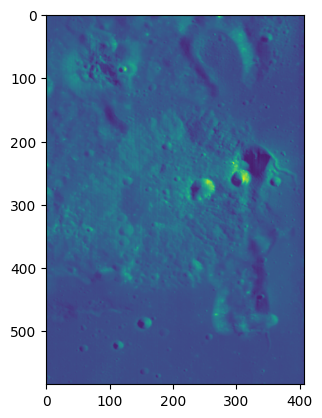

In [2]:
#Getting Raw Spectral Data and placing it in mydata ojbect.
mydata = NeuralNetData('C:/Users/zvig/.julia/dev/JENVI.jl/Data/targeted.hdf5')
print(f'Loaded in data of shape: {mydata.smoothspec.shape}')
print(f'Reminder: (bands,ydimension,xdimension)')
plt.imshow(mydata.smoothspec[1,:,:])

#### Label Creation for Supervised Learning

In [3]:
#Creating data labels based on the Spectral ANgle Mapper (SAM) technique.

# Defining reference spectra for labeling.
olpt = (200,284)
refspec1 = mydata.smoothspec[:,*olpt] #olivine
olcheck = mydata.contrem[:,*olpt]
refspec2 = mydata.smoothspec[:,500,200] #mare (South)
refspec3 = mydata.smoothspec[:,190,360] #mare (North)
refspec4 = mydata.smoothspec[:,300,200] #dome center
refspec5 = mydata.smoothspec[:,320,100] #dome flank
refspec_raw = mydata.rawspec[:,200,280]
refspec_dict = {'Olivine':(refspec1,1.2),'Mare1':(refspec2,1),'Mare2':(refspec3,0.7),'Dome1':(refspec4,1),'Dome2':(refspec5,1)} #Dictionary of tuples {str:(array,threshold)}

#Labeling data by modifying mydata object
mydata.label_data('Spectral_Angle',refspec_dict)

c:\Users\zvig\Desktop\python_code\ClassifyHySpecMoon\classifyhyspecmoon\create_labels.py:23: RuntimeWarning: invalid value encountered in arccos
  spa = 180*np.arccos(np.einsum('ijk,ijk->ij',M,I)/(np.linalg.norm(M,axis=2)*np.linalg.norm(I,axis=2)))/np.pi


In [4]:
mydata.onehot_encoding()

In [5]:
hyperparams = MyHyperParameters(
    nlyrs = 5,
    npl = [50]*5,
    apl = ['relu']*5,
    lrate = 0.001,
    batch_size = 1400,
    nepochs = 50
    )

mydata.split_train_test()
mydata.minmax_normalization((0,1))
print(mydata.X_train.shape)
print(mydata.Y_train.shape)

(178704, 239)
(178704, 7)


In [6]:
model,hist,pred_encoded = run_mlp(mydata,hyperparams)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                12000     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 7)                 357       
                                                                 
Total params: 22557 (88.11 KB)
Trainable params: 22557 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                12000     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 7)                 357       
                                                                 
Total params: 22557 (88.11 KB)
Trainable params: 22557 (

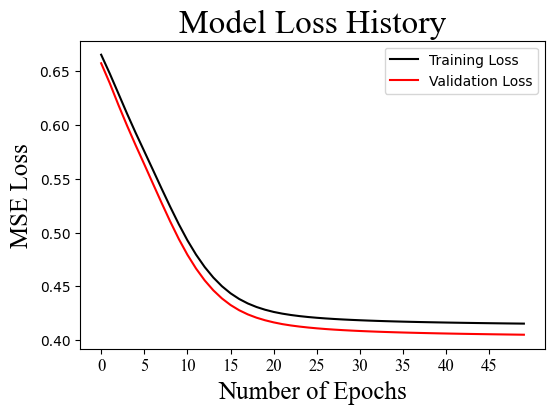

In [7]:
fancyfont = {'fontname':'Times New Roman'}
font = fnt_mang.FontProperties(family='Times New Roman',style='normal',size=10)

#Loss-validation curve
model.summary()

# print(mydata.Y_train)
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(range(0,hyperparams.nepochs),hist.history['loss'],c='k',label='Training Loss')
ax.plot(range(0,hyperparams.nepochs),hist.history['val_loss'],c='r',label='Validation Loss')
ax.legend()

ax.set_title('Model Loss History',**fancyfont,fontsize=24)
ax.set_xlabel('Number of Epochs',**fancyfont,fontsize=18)
ax.set_ylabel('MSE Loss',**fancyfont,fontsize=18)
ax.set_xticks(np.arange(0,hyperparams.nepochs,5),labels=np.arange(0,hyperparams.nepochs,5),**fancyfont,fontsize=12)
# ax.set_yticks(np.arange(1.5,4.5,0.5),labels=np.arange(1.5,4.5,0.5),**fancyfont,fontsize=12)
# plt.ylim(0,0.5)

plt.savefig('G:/My Drive/Machine Learning Project/Figures/Loss_History_onehot.png',dpi=300)

Training Data: 178704 (75%)
Testing Data: 59568 (25%)
Labeled Training Data: 59568
Predicted Test Data: 59568
dict_values([3060, 788, 12041, 4328, 4837, 7569, 26945])
dict_values([0, 0, 1, 510, 0, 59057, 0])
0
0
59568
59568


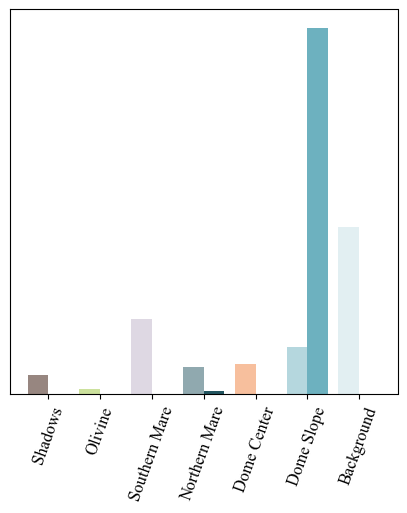

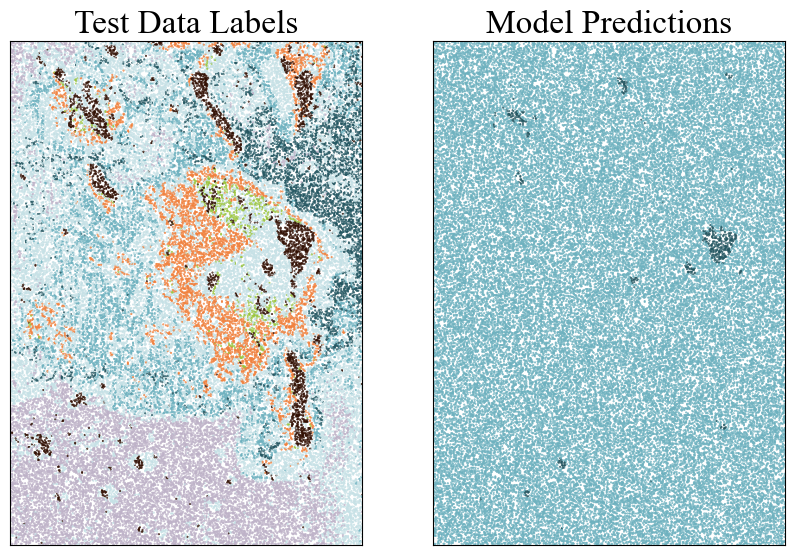

In [8]:
c = ['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6']
c_map = ListedColormap(['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6'])
class_names = ['Shadows','Olivine','Southern Mare','Northern Mare','Dome Center', 'Dome Slope','Background']

lab = np.argmax(mydata.Y_test,axis=1)
pred = np.argmax(pred_encoded,axis=1)


label_dist = {}
pred_dist = {}
for i in range(0,len(class_names)):
    label_dist[class_names[i]] = mydata.Y_test[lab==i].shape[0]
    pred_dist[class_names[i]] = pred[pred==i].shape[0]

print(f'Training Data: {len(mydata.Y_train)} ({len(mydata.Y_train)/mydata.num_pixels:.0%})')
print(f'Testing Data: {len(mydata.Y_test)} ({len(mydata.Y_test)/mydata.num_pixels:.0%})')
tot_label = np.array(list(label_dist.values())).sum()
tot_pred = np.array(list(pred_dist.values())).sum()
print(f'Labeled Training Data: {tot_label}')
print(f'Predicted Test Data: {tot_pred}')

print(label_dist.values())
print(pred_dist.values())

#Class Distributions
fig1,ax = plt.subplots(1,1,figsize=(5,5))
width=0.4
ax.bar(np.arange(0,len(class_names))-width/2,list(label_dist.values()),width=width,color=c,alpha=0.5)
ax.bar(np.arange(0,len(class_names))+width/2,list(pred_dist.values()),width=width,color=c)
ax.set_xticks(np.arange(0,len(class_names)))
ax.set_xticklabels(class_names,**fancyfont,fontsize=12,rotation=70)
ax.set_yticks([])

#Spatial Relations

fig2,[ax1,ax2] = plt.subplots(1,2,figsize=(10,12))
ax1.imshow(mydata.labeled_data,interpolation='none',cmap=c_map,alpha=0)
ax1.scatter(mydata.xcoord_test,mydata.ycoord_test,marker='.',s=0.8,c=lab,cmap=c_map)

ax2.imshow(mydata.labeled_data,interpolation='none',cmap=c_map,alpha=0)
ax2.scatter(mydata.xcoord_test,mydata.ycoord_test,marker='.',s=0.8,c=pred,cmap=c_map,vmin=0,vmax=6)

ax1.set_title('Test Data Labels',fontdict={'size':24,'family':'Times New Roman'})
ax2.set_title('Model Predictions',fontdict={'size':24,'family':'Times New Roman'})

ax1.set_xticks([]),ax1.set_yticks([])
ax2.set_xticks([]),ax2.set_yticks([])

print(np.count_nonzero(mydata.Y_test==6))
print(np.count_nonzero(pred==6))

print(np.array(list(label_dist.values())).sum())
print(np.array(list(pred_dist.values())).sum())

# plt.savefig('G:/My Drive/Machine Learning Project/Figures/Model Performance.png',dpi=800)

([<matplotlib.axis.YTick at 0x20803a95f10>,
 [Text(0, 0, 'Shadows'),
  Text(0, 1, 'Olivine'),
  Text(0, 2, 'Southern Mare'),
  Text(0, 3, 'Northern Mare'),
  Text(0, 4, 'Dome Center'),
  Text(0, 5, 'Dome Slope'),
  Text(0, 6, 'Background')])

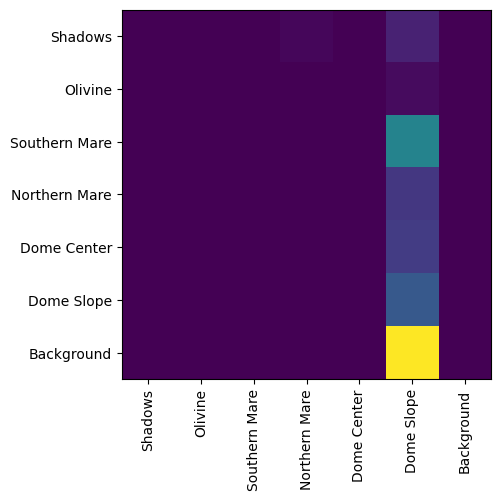

In [9]:
import sklearn.metrics

conf = sklearn.metrics.confusion_matrix(lab,pred)
plt.imshow(conf)
plt.xticks(np.arange(7),class_names,rotation=90)
plt.yticks(np.arange(7),class_names)